In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import logging
import time

from lisagwresponse import GalacticBinary
from lisainstrument import Instrument

from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho

from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn

In [2]:
# orbit_path = '../orbits/keplerianupsampled.h5'
# orbit_path = '../orbits/kep-1hz30d.h5'
orbit_path = '../orbits/keplerian_long.h5'
gw_path = 'gws.h5'

# Setup simluation parameters
fs = 0.1    # Hz
day = 86400 # s
duration = day # X days
size = duration*fs
discard = 300

rec = ['A','E','T']

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']
    orbit_fs = 1/orbits.attrs['dt']
    orbit_dur = orbits.attrs['tsize']/orbit_fs
    print ("fs = "+str(fs)+" Hz,  orbit_duration = "+str(orbit_dur/day)+" d")


# True values of inserted parameters
Amp_true = 5e-17
f_true = 1e-3
phi0_true = 0

fs = 0.1 Hz,  orbit_duration = 1500.0 d


In [3]:
# Setup galactic binary to insert in simulation
# !rm gws.h5

# # #source = GalacticBinary(A=6.4e-23, f=6.22e-3, orbits=orbit_path, t0=orbits_t0+10, gw_beta=0,gw_lambda=0) #HM Cnc
# source = GalacticBinary(A=Amp_true, f=f_true, phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0, dt=1/fs, size=size+300)
# # #source = GalacticBinary(A=5E-20, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0)
# # #source = GalacticBinary(A=1E-16, f=1E-2, orbits=orbit_path ,t0=orbits_t0 + 10, gw_beta=0, gw_lambda=0) #ridiculously loud binary

# source.write("gws.h5")

In [4]:
# Setup logger (sometimes useful to follow what's happening)

# logging.basicConfig()
# logging.getLogger('lisainstrument').setLevel(logging.INFO)

In [5]:
# Create 'realistic' orbit with signal and noise

# sample_instru = Instrument(
#     size=size, # in samples
#     dt=1/fs,
#     aafilter=('kaiser', 240, 0.275*fs, 0.725*fs),
#     orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
#     gws=gw_path
# )
# sample_instru.disable_all_noises()
# sample_instru.simulate()

In [6]:
# Write out data to sample file
# NOTE: Remember to remove the old sample file.

# !rm measurements/MCMCsample3600s.h5
# !rm measurements/MCMCsample86400s.h5
# !rm measurements/MCMCsample172800s.h5
# !rm measurements/MCMCsample432000s.h5
# !rm measurements/MCMCsample1728000s.h5
# !rm measurements/MCMCsample2592000s.h5

# sample_instru.write('measurements/MCMCsample'+str(int(duration))+'s.h5')


In [7]:
# Read data from LISA Instrument

# rawdata = Data.from_instrument('measurements/MCMCsample'+str(int(duration))+'s.h5')

# t0 = time.time()
# A = ortho.A2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t1 = time.time()
# print ("Time to build and run A2 = "+str(t1-t0))
# E = ortho.E2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t2 = time.time()
# print ("Time to build and run E2 = "+str(t2-t1))
# T = ortho.T2.build(**rawdata.args)(rawdata.measurements)[discard:]
# t3 = time.time()
# print ("Time to build and run T2 = "+str(t3-t2))

# #t = sample_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/fs)[discard:]

# sdata = np.array([t,A,E,T])

# # Extract A, E, T data to speed up re-running code.
# filepath = 'measurements/MCMCsample'+str(int(duration))+'s.txt'
# filecontent = Table(sdata.T, names=['t','A','E','T'])
# ascii.write(filecontent, filepath, overwrite=True)

# t4 = time.time()
# print ("Total time = "+str(t4-t0))

In [8]:
# Retreive A, E, T data
rawdata = ascii.read('measurements/MCMCsample'+str(int(duration))+'s.txt')
sdata = np.array([rawdata['t'],rawdata['A'],rawdata['E'],rawdata['T']])

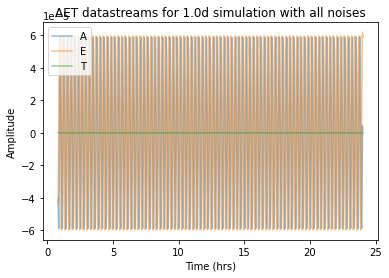

In [9]:
for i in range(3):
    plt.plot(sdata[0]/3600,sdata[i+1],label=rec[i],alpha=.5)
plt.title('AET datastreams for '+str(duration/day)+'d simulation with all noises')
plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Amplitude')
plt.show()

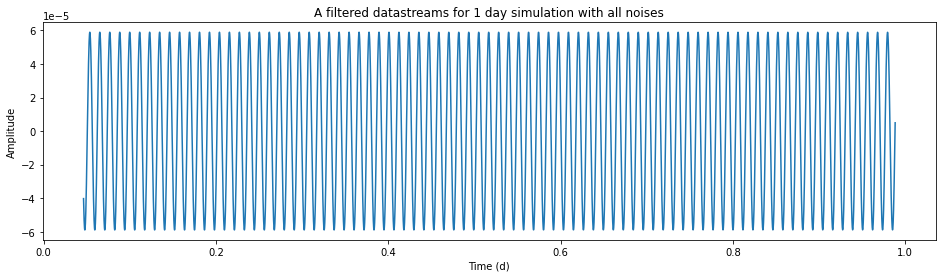

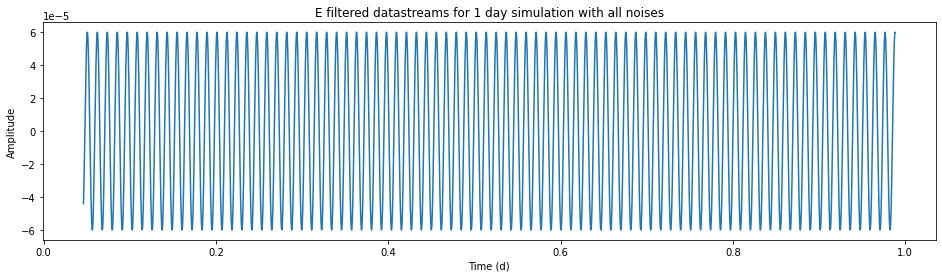

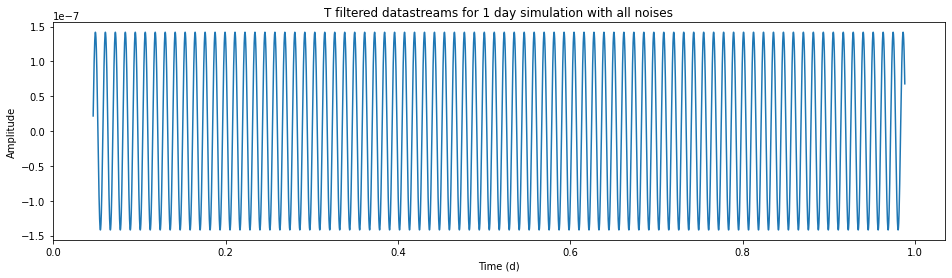

In [10]:
def psd_func(data):
    return scipy.signal.welch(data,fs=fs,window='nuttall',nperseg=len(data),detrend=False)

# Create psd for data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(sdata[i])
    tmp.append(psdtmp)
psd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])


# Create filtered data
cutoff = 100
tmp = []
#coeffs = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=fs)
#coeffs = scipy.signal.firls(73, bands=[0,1e-2,3e-2,5e-2], desired=[1,1,0,0],fs=fs)
coeffs = scipy.signal.firls(73, bands=[0,5e-3,1e-2,fs/2], desired=[1,1,0,0],fs=fs)
for i in range(1,4):
    fdata_tmp = scipy.signal.filtfilt(coeffs,1., x=sdata[i],padlen=len(psd[0]))
    tmp.append(fdata_tmp[cutoff:-cutoff])
fsdata = np.array([sdata[0][cutoff:-cutoff],tmp[0],tmp[1],tmp[2]])

# Create psd for filtered data
tmp = []
for i in range(1,4):
    ftmp, psdtmp = psd_func(fsdata[i])
    tmp.append(psdtmp)
fpsd = np.array([ftmp,tmp[0],tmp[1],tmp[2]])

for i in range(3):
    plt.figure(figsize=(16,4))
    plt.plot(fsdata[0]/day,fsdata[i+1])
    plt.title(rec[i]+' filtered datastreams for 1 day simulation with all noises')
    plt.xlabel('Time (d)')
    plt.ylabel('Amplitude')
    #plt.xlim(.25,1)
    plt.show()

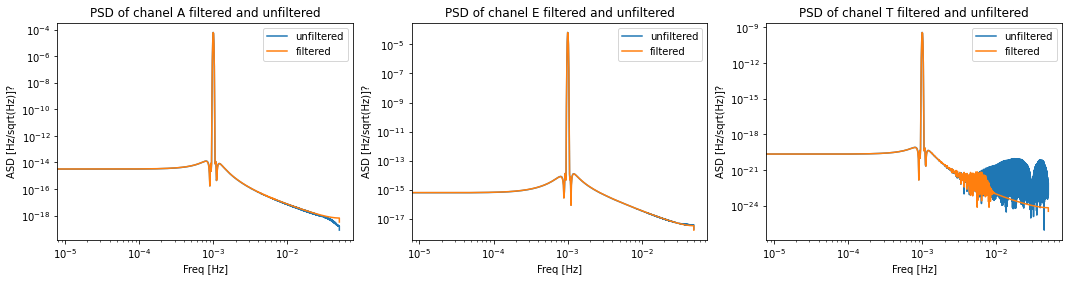

In [11]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(18)
for i in range(3):
    axs[i].plot(psd[0],psd[i+1], label='unfiltered')
    axs[i].plot(fpsd[0],fpsd[i+1], label='filtered')
    axs[i].legend()
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Freq [Hz]')
    axs[i].set_ylabel('ASD [Hz/sqrt(Hz)]?')
    axs[i].set_title("PSD of chanel "+rec[i]+' filtered and unfiltered')
plt.show()

In [12]:
# Difference factor between pytdi.Data.from_instrument and pytdi.Data.from_gws

def dphi_to_dnu(time,data,f_gw = f_true):
    laser_freq = 2.816E14 #Hz, gotten from lisainstrument code
    dt = 1/fs
    # dt = np.mean((time[1:]-time[:-1]))
    return np.diff(data) * ((laser_freq) / (2*np.pi*f_gw*dt))

# Building The Galactic Binary MCMC fit
Here is a list of things that can be done to speed up the model simulation function:
1) Stop exporting and importing GalBin data and simulated data, but directly input them in functions
2) Improve the AET calculation times & simulation setup times (takes 4s)
3) Decrease sampling rate of LISA instrument
4) 

In [13]:
# Generate random binary to be able to build the TDI chanels
time_elapsed = []
time_elapsed.append(time.time())

GalBin = GalacticBinary(A=Amp_true, f=f_true,phi0=phi0_true, orbits=orbit_path ,t0=orbits_t0+10, gw_beta=0, gw_lambda=0,dt=1/fs,size=size+300)
GalBin.write('gw_tmp.h5')

time_elapsed.append(time.time()) 
rawdata = Data.from_gws('gw_tmp.h5',orbit_path,interpolate=True)#, skipped=-int(size))
time_elapsed.append(time.time())

Afunc = ortho.A2.build(**rawdata.args)
time_elapsed.append(time.time())
A = Afunc(rawdata.measurements)[discard:]
time_elapsed.append(time.time())

tmp = np.array(time_elapsed)[1:] - np.array(time_elapsed[:-1])
print ("gw_gen = {:.3f}, signal_gen = {:.3f}, TDIbuild = {:.3f}, TDIcalc = {:.3f}, Total = {:.3f}".format(*tmp,time_elapsed[-1]-time_elapsed[0]))

t = GalBin.t[discard:]
# t = model_instru.t[discard:]
# t = (np.arange(0,len(A)+discard)/4)[discard:]
mdata = np.array([t,A])

!rm gw_tmp.h5

# Without interpolate, for 30 days it takes 7s, with interpolate it takes 0.66s
#but it takes 1.8s to generate the GW's as apposed to 0.68s

gw_gen = 0.095, signal_gen = 0.067, TDIbuild = 0.578, TDIcalc = 0.021, Total = 0.761


(8640,) (8640,)


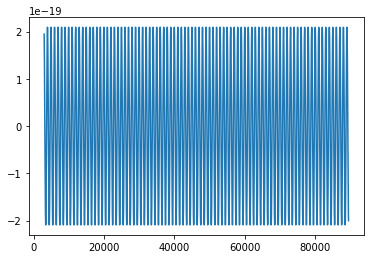

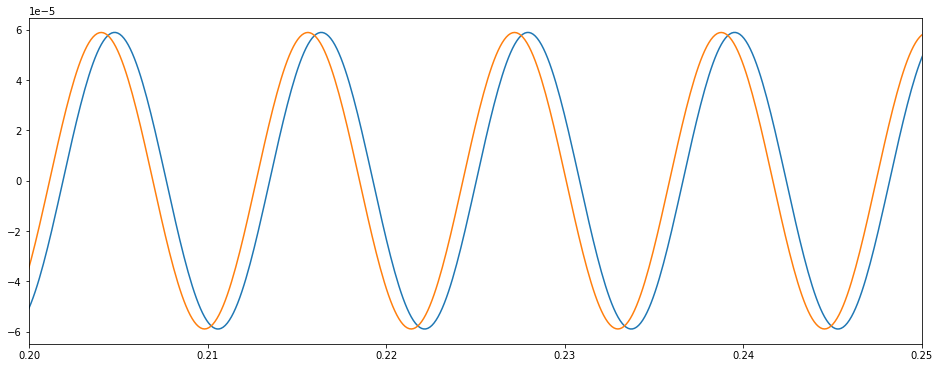

In [14]:
print (t.shape,A.shape)
plt.plot(t,A)
plt.show()
plt.figure(figsize=(16,6))
plt.plot(t[:-1]/day,dphi_to_dnu(t,A,f_true))
plt.plot(fsdata[0]/day,fsdata[1])
plt.xlim(0.2,0.25)
plt.show()

In [15]:
# Defining the model used for MCMC fitting

def model(st, Amp, f_gw, phi0, t0=orbits_t0+10, gw_beta=0,gw_lambda=0):
    GalBin = GalacticBinary(A=Amp, f=f_gw, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=gw_beta, gw_lambda=gw_lambda, dt=1/fs, size=size+300)
    GalBin.write('gw_tmp.h5')
    
    # rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path,interpolate=True)
    mA = Afunc(rawdata.measurements)[discard:]
    #E = Efunc(rawdata.measurements)[discard:]
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    mt = GalBin.t[discard:]
    
    !rm gw_tmp.h5
    
    # Generate correct amplitude to be compatible with sample data
    nmt = np.copy(mt)[:-1]
    nmA = dphi_to_dnu(mt,mA,f_gw)
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(nmt, st))[0]
    nnmt, nnmA = nmt[time_indices], nmA[time_indices]

    return np.array([nnmt,nnmA])
    # return np.array([t,A,E,T])

Time elapsed = 0.28
[ 4000.  4010.  4020. ... 85370. 85380. 85390.]
[ 4000.  4010.  4020. ... 85370. 85380. 85390.]


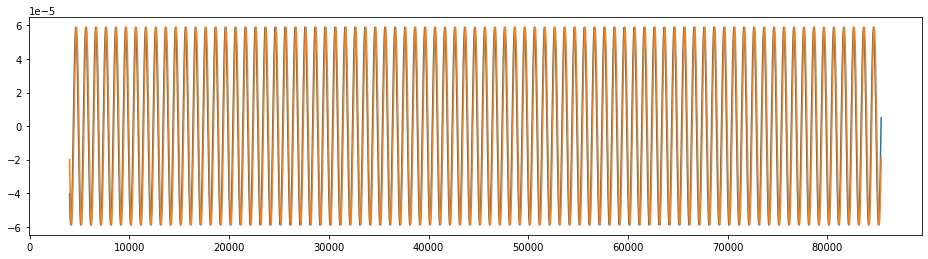

In [16]:
script_time0 = time.time()

test = model(fsdata[0],Amp_true,f_true,phi0_true)

script_time1 = time.time() - script_time0
print ("Time elapsed = {:.2f}".format(script_time1))

plt.figure(figsize=(16,4))
plt.plot(fsdata[0],fsdata[1])
plt.plot(test[0],test[1])
plt.plot()
print (fsdata[0])
print (test[0])

In [17]:
# Plot of time it takes to run one simulation without noise

# script_duration_1ch = np.array([[0.01,0.1,0.5,1,4,12,24], [7.57,6.97,9.48,13.05,34.75,113.05,214.22]]) # first list is simulation [hrs], second list is script duration [s]
# script_duration_3ch = np.array([[1,4,12,24],[24.39,95.74,282.75,738.35]]) # first list is simulation [hrs], second list is script duration [s]

# plt.figure(figsize=(12,8))
# plt.plot(script_duration_1ch[0],script_duration_1ch[1]/60,marker='o',label='Only A')
# plt.plot(script_duration_3ch[0],script_duration_3ch[1]/60,marker='o',label='A, E, T')
# plt.legend()
# plt.ylabel('Script duration [minutes]')
# plt.xlabel('Simulation duration [hrs]')
# plt.title('Simulation duration of noise free data with galactic binary')
# plt.savefig("Computationtime.jpg")
# plt.grid()
# plt.ylim(ymin=0)
# plt.show()

In [18]:
# Define functions needed for mcmc fitting
import emcee
from tqdm import tqdm

theta_prior = np.array([
    [1e-22,1e-10],
    [1e-5,1e-2],
    [-np.pi,np.pi]
])
A_prior, f_prior, phi0_prior = theta_prior

def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    Amp, f, phi0 = theta
    newt, y_model = model(t,*theta)
    
    return -0.5*(np.sum((y-y_model)**2))

def lnprior(theta):
    """
    Define a prior that allows the parameters between certain limits. Between the limits it is flat.     
    """
    Amp, f, phi0= theta
    
    if A_prior[0] < Amp < A_prior[1] and f_prior[0] < f < f_prior[1] and phi0_prior[0] < phi0 < phi0_prior[1]:
        return 0.0
    return -np.inf

def lnprob(theta, t, y):
    """
    The likelihood to include in the MCMC.
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, t, y)

In [19]:
# Set up the properties of the problem.
ndim, nwalkers = 3, 100

# My guess at a solution
print ("A_true = {}, f_true = {}, phi0 = {}".format(Amp_true,f_true,phi0_true))

# Guesses
Amp_guess = Amp_true 
f_guess = f_true # Hz
phi0_guess = phi0_true #rad
#theta_guess = np.array([Amp_guess, f_guess])

theta_guess = np.array([Amp_guess,f_guess,phi0_guess])
theta_true = np.array([Amp_true,f_true,phi0_true])
#theta_true = np.array([2.8e-4, 1e-2, np.pi*.6])

A_true = 5e-17, f_true = 0.001, phi0 = 0


In [20]:
# Give the walkers all a slightly different starting position 
#such that they will walk different paths

pos_Amp = Amp_guess + 1e-20*np.random.randn(nwalkers)
pos_f = f_guess + 1e-5*np.random.randn(nwalkers)
pos_phi0 = phi0_guess +1e-2*np.random.randn(nwalkers)

pos = np.array([pos_Amp,pos_f, pos_phi0]).T
#print (pos)
# pos = np.array([theta_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)])
# print (pos)

# pos = [theta_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [21]:
# We can now run emcee by setting up a sampler

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(fsdata[0], fsdata[1]))

# Determines how many steps the walkers take. Usually the first 25/50 steps have to be neglected
MCMC_steps = 750

In [22]:
# Run sampler for MCMC_steps steps, now with progress bar :)
# t0 = time.time()
# for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=MCMC_steps)):
#     pass
# t1 = time.time() - t0 
# print ("Time elapsed wfilt = {:.2f}".format(t1))

In [23]:
# Run sampler for MCMC_steps steps (10walkers 150 steps took 16.5 minutes)

# t0 = time.time()
# tmp2 = sampler.run_mcmc(pos,MCMC_steps)
# t1 = time.time() - t0
# print ("Time elapsed wfilt = {:.2f}".format(t1))

In [24]:
# Now comes analysing the output
# print (sampler.chain.shape)

# print (sampler.chain[:,:,0])

In [26]:
# Plot the result

i=0
plt.plot(sampler.chain[:,:,i].transpose(), color='black', alpha=0.3)
plt.plot([0,MCMC_steps],[theta_true[i]]*2,c='red')
plt.title("MCMC on filtered data")
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.yscale('log')
plt.ylim(A_prior)
plt.show()

i=1
plt.plot(sampler.chain[:,:,i].transpose(), color='black', alpha=0.3)
plt.plot([0,MCMC_steps],[theta_true[i]]*2,c='red')
plt.title("MCMC on filtered data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples')
plt.yscale('log')
plt.ylim(f_prior)
plt.show()

i=2
plt.plot(sampler.chain[:,:,i].transpose(), color='black', alpha=0.3)
plt.plot([0,MCMC_steps],[theta_true[i]]*2,c='red')
plt.title("MCMC on filtered data")
plt.ylabel('Phase offset [rad]')
plt.xlabel('Samples')
plt.ylim(phi0_prior)
plt.show()


# # Extract MCMC data to speed up re-running code.
# for j,par in zip(range(3),["A","f","phi0"]):
#     filepath = 'measurements/MCMCfit'+par+'.txt'
#     filecontent = Table(sampler.chain[:,:,j].transpose(), names=['w'+ str(i) for i in range(nwalkers) ])
#     ascii.write(filecontent, filepath, overwrite=True)

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [27]:
# After X samples, the mcmc stabalises so we cut away the part before that 
mcmc_cutoff = 50

tmp0 = []
tmp0_cut = []
for j,par in zip(range(3),["A","f","phi0"]):
    filepath = 'measurements/MCMCfit'+par+'.txt'
    tmp1 = []
    tmp2 = ascii.read(filepath)
    for i in range(nwalkers):
        tmp1.append(tmp2['w'+str(i)])
    tmp0.append(np.array(tmp1))
    tmp0_cut.append(np.array(tmp1)[:, mcmc_cutoff:].reshape((-1, 1))[:,0])
samples = np.array(tmp0)
samples_cut = np.array(tmp0_cut)


#samples_nfilt_cut = sampler_nfilt.chain[:, mcmc_cutoff:, :].reshape((-1, 1))[:,0]
# samples_wfilt_cut = sampler_wfilt.chain[:, mcmc_cutoff:, :].reshape((-1, 1))[:,0]
print (samples.shape)
print (samples_cut.shape)

(3, 100, 750)
(3, 70000)


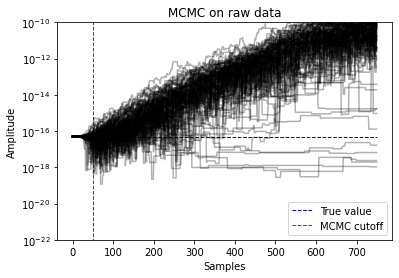

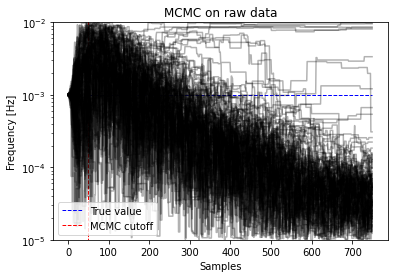

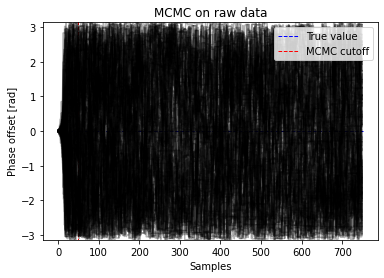

In [28]:
def mcmc_plot(dat, step, cutoff, true, log,ylab, lims):
    plt.plot([0,step],[true]*2,c='b',linestyle='dashed',linewidth=1,label='True value')
    plt.plot([cutoff]*2, [-1e20,1e20],c='red',linestyle='dashed',linewidth=1,label='MCMC cutoff')
    #add [plot of prior]
    plt.plot(dat.T, color='black', alpha=0.3)
    plt.title("MCMC on raw data")
    plt.ylabel(ylab)
    plt.xlabel('Samples')
    if log:
        plt.yscale('log')
    plt.legend()
    plt.ylim(lims)
    plt.show()

for i,true,log, lims,ylab in zip(range(3),theta_true, [True, True, False], theta_prior,['Amplitude','Frequency [Hz]','Phase offset [rad]']):
    mcmc_plot(samples[i], MCMC_steps, mcmc_cutoff, true, log,ylab,lims)

(3, 70000)


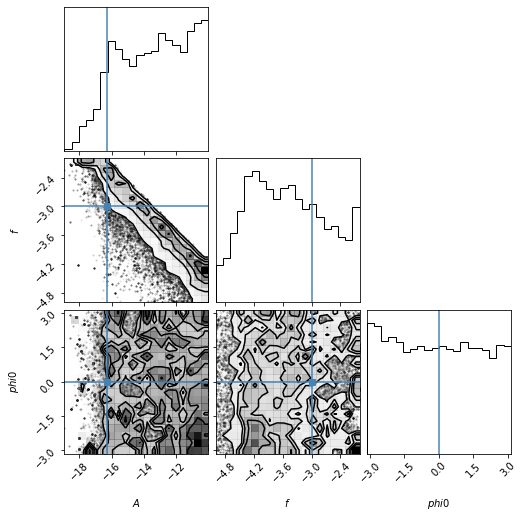

In [29]:
import corner
print (samples_cut.shape)

fig = corner.corner(np.array([np.log10(samples_cut[0]),np.log10(samples_cut[1]),samples_cut[2]]).T,labels=["$A$", "$f$", "$phi0$"],\
                    truths=[np.log10(theta_true[0]),np.log10(theta_true[1]),theta_true[2]])#, quantiles=[0.16, 0.5, 0.84], show_titles=True)

[[ 1.00000000e-22  1.00000000e-10]
 [ 1.00000000e-05  1.00000000e-02]
 [-3.14159265e+00  3.14159265e+00]]
[1.e-22 1.e-10]


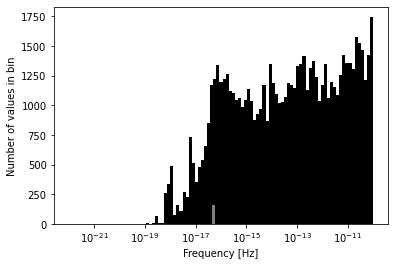

[1.19146108e-16 5.51457090e-14 1.16032101e-11]
So A = 0.00000^+0.00000-0.00000
True A = 5e-17


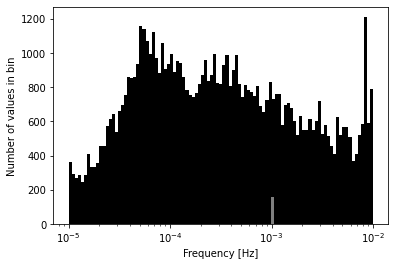

[4.65996086e-05 2.79141023e-04 2.62339545e-03]
So f = 0.00028^+0.00023-0.00234
True f = 0.001


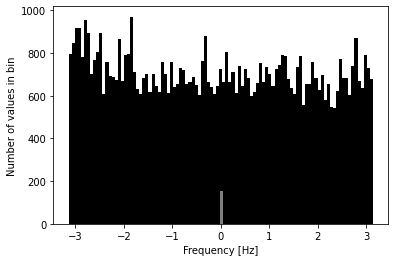

[-2.2660688  -0.10336925  2.08689255]
So phi0 = -0.10337^+2.16270-2.19026
True phi0 = 0.0


In [30]:
#priors : 1e-6 < Amp < 1 and 5e-4 < f < 5e-1 and -np.pi < phi0 < np.pi:
print (theta_prior)
print (theta_prior[0])

nbins = 100
bins = []
for i in range(len(theta_true)-1):
    bins.append(np.logspace(np.log10(theta_prior[i][0]),np.log10(theta_prior[i][1]),nbins))
bins.append(np.linspace(phi0_prior[0],phi0_prior[1],nbins))

for i,l,log in zip(range(3),['A','f','phi0'],[True,True,False]):
    plt.hist(samples_cut[i],bins[i],color='black')
    plt.plot([theta_true[i]]*2,[0,150],c='white',linewidth=3,alpha=.5)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Number of values in bin")
    if log:
        plt.xscale('log')
    plt.show()


    summary = np.percentile(samples_cut[i], [16, 50, 84])
    print (summary)
    print ("So {} = {:.5f}^+{:.5f}-{:.5f}".format(l,summary[1],summary[1]-summary[0],summary[2]-summary[1]))
    print ("True {} = {}".format(l,theta_true[i]))

In [ ]:
stop
def model(st, Amp, f, phi0, t0=orbits_t0+10, gw_beta=0,gw_lambda=0):
    GalBin = GalacticBinary(A=Amp, f=f, phi0=phi0, orbits=orbit_path, t0=t0, gw_beta=gw_beta, gw_lambda=gw_lambda, dt=1/fs, size=size+300)
    GalBin.write('gw_tmp.h5')
    
    rawdata = Data.from_gws( 'gw_tmp.h5', orbit_path)
    A = Afunc(rawdata.measurements)[discard:]
    #E = Efunc(rawdata.measurements)[discard:]
    
    # If we only fit signal parameters, we don't include T since it has by definition no signal.
    #T = Tfunc(rawdata.measurements)[discard:]
    
    t = GalBin.t[discard:]
    
    !rm gw_tmp.h5
    
    # Make sure that the model generates data at the correct time
    time_indices = np.where(np.in1d(t, st))[0]
    nmt, nA = t[time_indices], A[time_indices]

    return np.array([nmt,nA])
    # return np.array([t,A,E,T])

In [ ]:
def lnL(theta, t, y):
    """
    The log likelihood of our simplistic Linear Regression. 
    """
    Amp, f, phi0 = theta
    t_model, y_model = model(t,*theta)
    
    plt.figure(figsize=(16,4))
    plt.plot(t/day,y,label='sym')
    plt.plot((t_model/day),y_model,label='gws')
    plt.title('A filtered datastreams for 1 day simulation with all noises')
    plt.xlabel('Time (d)')
    plt.ylabel('Amplitude')
    plt.xlim(np.min(t/day),.2)
    plt.legend()
    plt.show()
    
    return -0.5*(np.sum((y-y_model)**2))

In [ ]:
theta_true = np.array([2.8e-4, 1e-2, np.pi*.6])

tmp = lnL([2.8e-4, 1e-2, np.pi*.6], fsdata[0], fsdata[1])
print (tmp)
tmp = lnL([2.8e-4, 1e-3, np.pi*.6], fsdata[0], fsdata[1])
print (tmp)

# Testing to avoid errror in different length of sample an model data

In [ ]:
st,sm = np.copy(sdata[0]), np.copy(sdata[1])
mt,mm = np.copy(mdata[0]), np.copy(mdata[1])

print (st.shape,st)
print (mt.shape,mt)

In [ ]:
x,y = np.array([1,2,3,4,5]), np.array([2,3,4,5,6,7,8,9])

indices = np.where(np.in1d(mt, st))[0]

In [ ]:
print (indices)
print ((mt[indices]).shape)
print ((mm[indices]).shape)
print (st[1:])
print (len(sm[1:]))

In [ ]:
23549.26/3600